In [1]:
# Bibliotecas python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
%matplotlib inline

# Função para calcular moda.
from scipy import stats

# Formatação dos gráficos
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend

In [2]:
# Configurando o tema do gráfico
myrcs = {"axes.titleweight": "bold", "lines.markersize": 9.0, "lines.linewidth": 2.0,}
sns.set (style="whitegrid", font_scale=1.25, rc=myrcs)

# Linhas exibidas por padrão nos dataframes
pd.options.display.min_rows = 20

In [3]:
# Parâmetros que variam nesta simulação
seeds = [10,20]
cargas = ["25hosts", "50hosts", "75hosts", "100hosts"]

# Tempo total de simulação
t_sim = 1000

In [4]:
# Função para ler os arquivos de log
def mymode (series):
    return stats.mode (series)[0]

agg_map = {'SwAtivosAntes' : mymode, 'SwAtivosDepois' : mymode, 'AvgCPULoad' : np.mean}

def read_dataframe ():
    df_slc = []
    for carga in cargas:
        df_sed = []
        for seed in seeds:
            df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+carga+"-"+str(seed)+"-logDecisaoSwitchesSW.txt", sep='\s+', index_col=["Time"])
            df_sed.append (df)
        df_slc.append (pd.concat (df_sed).groupby (["Time"]).agg (agg_map))
    df_read = pd.concat (df_slc, keys=cargas, names=["Carga"], copy=False)
    return df_read.reset_index ()

In [5]:
df_plot = read_dataframe()
#df_plot

In [6]:
df_hw = []
agg_maphw = {'LoaUsag' : np.mean, 'FloUsag' : np.mean, 'FloEntr' : np.mean,'LoaKbps' : mymode}
for carga in cargas:
    df_sed = []
    for seed in seeds:
        df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+carga+"-"+str(seed)+"-switch-stats-hw.log", sep='\s+', index_col=["TimeSec"])
        df_sed.append (df)
    df_hw.append (pd.concat (df_sed).groupby (["TimeSec"]).agg (agg_maphw))
df_hwstats = pd.concat (df_hw, keys=cargas, names=["Carga"], copy=False)
df_hwstats = df_hwstats.reset_index ()

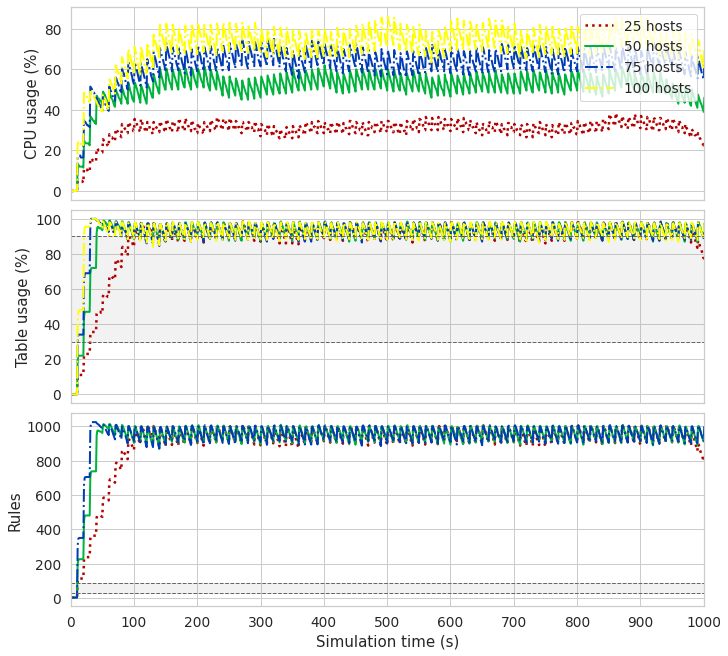

In [7]:
# Criando a figura com seus gráficos e eixo x compartilhado
fig = plt.figure (figsize=(10, 9), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=3, height_ratios=[1, 1, 1])
ax_tab = fig.add_subplot(spec[2])
ax_cpu = fig.add_subplot(spec[1], sharex=ax_tab)
ax_tft = fig.add_subplot(spec[0], sharex=ax_tab)

df_25 = df_hwstats.query ("Carga == '25hosts'")
df_50 = df_hwstats.query ("Carga == '50hosts'")
df_75 = df_hwstats.query ("Carga == '75hosts'")
df_100 = df_hwstats.query ("Carga == '100hosts'")
    
# Linha para o uso de CPU de cada carga
ax_tft.plot ("TimeSec", "LoaUsag", ":",  data=df_25, color="#b30000", label="25 hosts", linewidth=2.5)
ax_tft.plot ("TimeSec", "LoaUsag", "-",  data=df_50, color="#00b33c", label="50 hosts")
ax_tft.plot ("TimeSec", "LoaUsag", "-.", data=df_75, color="#003cb3", label="75 hosts")
ax_tft.plot ("TimeSec", "LoaUsag", "-.", data=df_100, color="#ffff00", label="100 hosts")
  
# Linha para o uso de tabela de cada carga
ax_cpu.plot ("TimeSec", "FloUsag", ":",  data=df_25, color="#b30000", label="25 hosts", linewidth=2.5)
ax_cpu.plot ("TimeSec", "FloUsag", "-",  data=df_50, color="#00b33c", label="50 hosts")
ax_cpu.plot ("TimeSec", "FloUsag", "-.", data=df_75, color="#003cb3", label="75 hosts")
ax_cpu.plot ("TimeSec", "FloUsag", "-.", data=df_100, color="#ffff00", label="100 hosts")

# Thresholds de uso de tabela
ax_cpu.axhspan (ymin=30, ymax=90, color='gray', alpha=0.1)
ax_cpu.axhline (y=30, color="#666666", lw=1, ls="--")
ax_cpu.axhline (y=90, color="#666666", lw=1, ls="--")

# Linha para o numero de regras de cada carga
ax_tab.plot ("TimeSec", "FloEntr", ":",  data=df_25, color="#b30000", label="25 hosts", linewidth=2.5)
ax_tab.plot ("TimeSec", "FloEntr", "-",  data=df_50, color="#00b33c", label="50 hosts")
ax_tab.plot ("TimeSec", "FloEntr", "-.", data=df_75, color="#003cb3", label="75 hosts")

# Thresholds de uso de tabela
ax_tab.axhspan (ymin=30, ymax=90, color='gray', alpha=0.1)
ax_tab.axhline (y=30, color="#666666", lw=1, ls="--")
ax_tab.axhline (y=90, color="#666666", lw=1, ls="--")
    
# Ajuste do eixo y
ax_tft.set_ylabel ("CPU usage (%)", )
ax_cpu.set_ylabel ("Table usage (%)")
ax_tab.set_ylabel ("Rules")
# ax_tft.set_ylim (0.8, 4.2)
# ax_tft.set_ylim (0.9, 4.1)
# ax_cpu.set_ylim (0, 100)
# ax_tab.set_ylim (0, 100)
# ax_tft.set_yticks ([1, 2, 3, 4])
# ax_tft.set_yticklabels (["1", "2", "", "4"])
# ax_cpu.set_yticks (range (0, 101, 25))
# ax_tab.set_yticks (range (0, 101, 25))

# Ajuste do eixo x
ax_tab.set_xlabel ("Simulation time (s)")
ax_tft.tick_params (labelbottom=False)
ax_cpu.tick_params (labelbottom=False)
ax_tab.set_xticks (np.arange(0, t_sim + 1, 100))
ax_tab.set_xlim (0, t_sim)

# Legendas
order = [0, 1, 2, 3]
handles, labels = ax_tft.get_legend_handles_labels()
ax_tft.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right')
   
# Finalizando e retornando a figura
plt.show ()

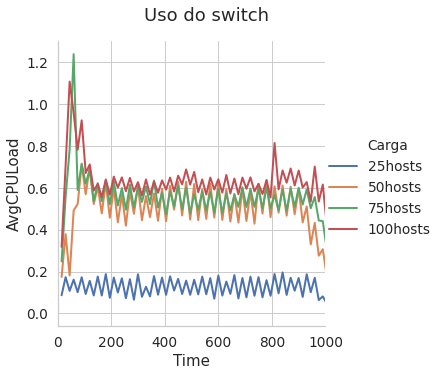

In [8]:
snsplt = sns.relplot(x="Time", y="AvgCPULoad",
            hue="Carga",
            kind="line", legend="full", data=df_plot, ci=None)
snsplt.fig.suptitle('Uso do switch', y=1.05)
snsplt.set(xlim=(0,1000))

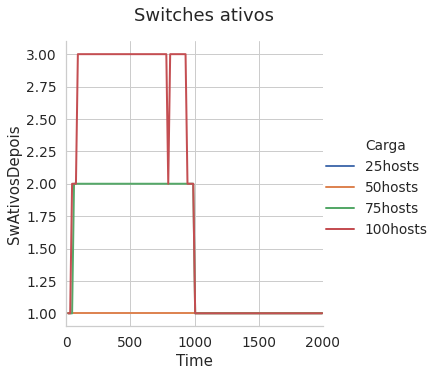

In [9]:
snsplt = sns.relplot(x="Time", y="SwAtivosDepois",
            hue="Carga",
            kind="line", legend="full", data=df_plot, ci=None)
snsplt.fig.suptitle('Switches ativos', y=1.05)
snsplt.set(xlim=(0,2000))

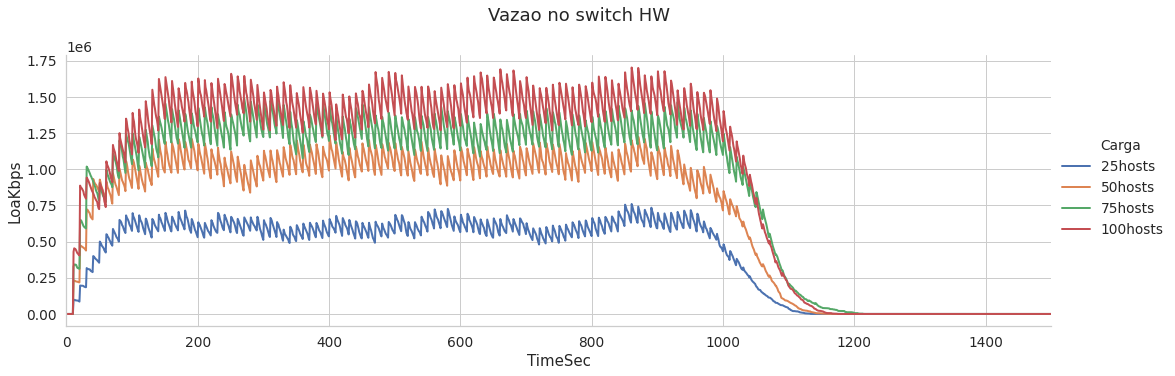

In [17]:
snsplt = sns.relplot(x="TimeSec", y="LoaKbps",
            hue="Carga",
            kind="line", legend="full", data=df_hwstats, ci=None, aspect=3)
snsplt.fig.suptitle('Vazao no switch HW', y=1.05)
snsplt.set(xlim=(0,1500))

In [11]:
#Lendo os arquivos de ping
def pings(dfP, switch):
    for s in seeds:
        for tempo in cargas:
            path = "saidas/"+carga+"/seed"+str(s)+"/"+carga+"-"+str(s)+"-ping"+switch+".txt" #caminho do arquivo
            with open(path) as stream:#Abre o arquivo
                times = [] #lista que armazenara todos os pings para coloca-los posteriormente em um series->dataframe
                seqs = []
                next(stream)  # Ignora a primeira linha do arquivo de entrada
                for line in stream: #Pega todas as linhas
                    string = line.split(" ") #String eh uma lista com cada palavra da linha
                    if(line != "Request timed out\n"): #Se a linha tiver o ping
                        for i in range(0,len(string)): #Para cada palavra na lista string, procura "time"
                            if(re.match(r'time', string[i])): #Pega somente os valores numericos da palavra
                                time = re.findall(r'\d.+', string[i])
                                times.append(float(time[0]))
                            if(re.match(r'seq', string[i])): #Pega somente os valores numericos da palavra
                                seq = re.findall(r'[0-9]+', string[i])
                                seqs.append(float(seq[0]))
                series = pd.Series(times) #Transforma a lista em uma Series
                series1 = pd.Series(seqs)
                ds = pd.DataFrame(series, columns=['Ping']) # E por fim em um dataframe
                ds['Seed'] = s
                ds['Carga'] = tempo
                ds['Switch'] = switch
                ds = ds.assign(Seq=pd.Series(seqs).values)
                dfP = pd.concat([dfP, ds])
    return dfP
dfPing = pd.DataFrame(columns=['Ping', 'Seed', 'Switch'])
dfPHW = pings(dfPing, 'HW')
dfPSW = pings(dfPing, 'SW')
dfPing = pd.concat([dfPing, dfPHW, dfPSW])
dfPing.reset_index(inplace=True)
del dfPing['index']
#dfPing.to_csv(r'pandas.txt', index=None, sep=' ', mode='a')
dfPing

,Ping,Seed,Switch,Carga,Seq
0,0.70692,10,HW,25hosts,0.0
1,0.70692,10,HW,25hosts,1.0
2,0.70692,10,HW,25hosts,2.0
3,0.70692,10,HW,25hosts,3.0
4,0.70692,10,HW,25hosts,4.0
5,0.70692,10,HW,25hosts,5.0
6,0.70692,10,HW,25hosts,6.0
7,0.70692,10,HW,25hosts,7.0
8,0.70692,10,HW,25hosts,8.0
9,0.70692,10,HW,25hosts,9.0


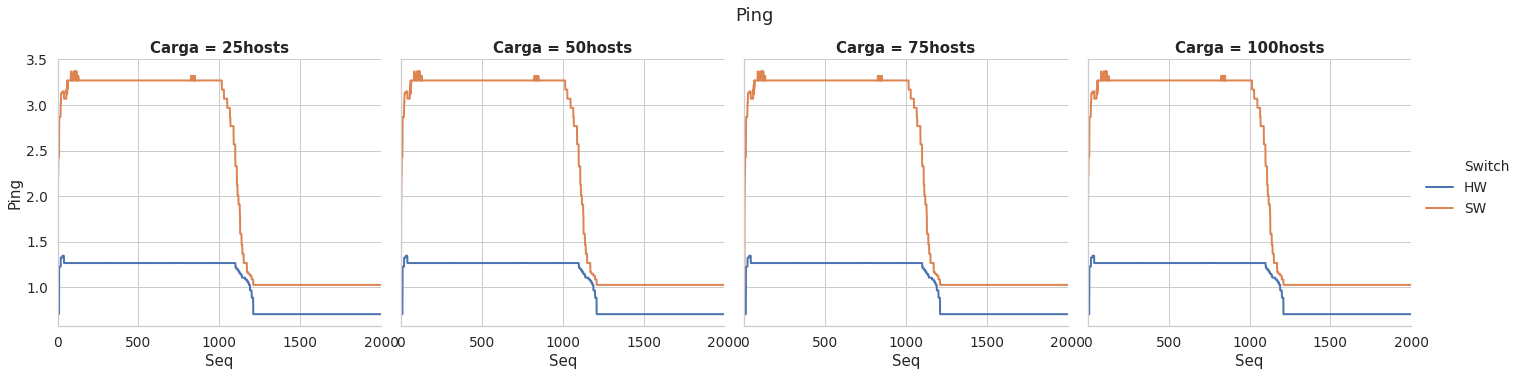

In [12]:
snsplt = sns.relplot(x="Seq", y="Ping",
            hue="Switch", col="Carga",
            kind="line", legend="full", data=dfPing, ci=None)
snsplt.fig.suptitle('Ping', y=1.05)
snsplt.set(xlim=(0,2000))

In [19]:
df_sw = []
agg_mapsw = {'LoaUsag' : np.mean, 'FloUsag' : np.mean, 'FloEntr' : np.mean,'Packets' : mymode, 'LoaDrps' : mymode}
for carga in cargas:
    df_sed = []
    for seed in seeds:
        df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+carga+"-"+str(seed)+"-switch-stats-sw1.log", sep='\s+', index_col=["TimeSec"])
        df_sed.append (df)
    df_sw.append (pd.concat (df_sed).groupby (["TimeSec"]).agg (agg_mapsw))
df_swstats = pd.concat (df_sw, keys=cargas, names=["Carga"], copy=False)
df_swstats = df_swstats.reset_index ()
df_swstats["%drop"] = df_swstats["LoaDrps"]/(df_swstats["Packets"]+df_swstats["LoaDrps"])
df_swstats

,Carga,TimeSec,LoaUsag,FloUsag,FloEntr,Packets,LoaDrps,%drop
0,25hosts,1.0,0.0,0.0,3.0,0,0,NaN
1,25hosts,2.0,0.5,0.0,9.0,278,0,0.0
2,25hosts,3.0,2.0,0.0,22.0,1015,0,0.0
3,25hosts,4.0,3.5,0.0,34.0,1688,0,0.0
4,25hosts,5.0,5.0,0.5,45.5,2208,0,0.0
5,25hosts,6.0,5.5,1.0,55.0,2654,0,0.0
6,25hosts,7.0,7.0,1.0,66.0,3449,0,0.0
7,25hosts,8.0,9.0,1.0,80.5,4264,0,0.0
8,25hosts,9.0,10.5,1.0,93.5,5528,0,0.0
9,25hosts,10.0,12.0,1.0,107.5,7027,0,0.0


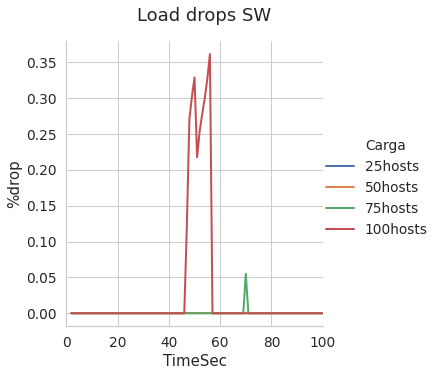

In [22]:
snsplt = sns.relplot(x="TimeSec", y="%drop",
            hue="Carga",
            kind="line", legend="full", data=df_swstats, ci=None)
snsplt.fig.suptitle('Load drops SW', y=1.05)
snsplt.set(xlim=(0,100))

In [23]:
df_bloq = []
agg_mapbloq = {'RegrasAceitas' : np.mean, 'RegrasBloqueadas' : np.mean}
for carga in cargas:
    df_sed = []
    for seed in seeds:
        df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+carga+"-"+str(seed)+"-regrasBloqueadas.txt", sep='\s+', index_col=["Time"])
        df_sed.append (df)
    df_bloq.append (pd.concat (df_sed).groupby (["Time"]).agg (agg_mapbloq))
df_bloqstats = pd.concat (df_bloq, keys=cargas, names=["Carga"], copy=False)
df_bloqstats = df_bloqstats.reset_index ()
df_bloqstats["%block"] = df_bloqstats["RegrasBloqueadas"]/(df_bloqstats["RegrasAceitas"]+df_bloqstats["RegrasBloqueadas"])
df_bloqstats

,Carga,Time,RegrasAceitas,RegrasBloqueadas,%block
0,25hosts,1.0,0.0,0,NaN
1,25hosts,2.0,12.5,0,0.0
2,25hosts,3.0,26.5,0,0.0
3,25hosts,4.0,37.0,0,0.0
4,25hosts,5.0,46.5,0,0.0
5,25hosts,6.0,57.5,0,0.0
6,25hosts,7.0,69.5,0,0.0
7,25hosts,8.0,84.5,0,0.0
8,25hosts,9.0,98.0,0,0.0
9,25hosts,10.0,110.5,0,0.0


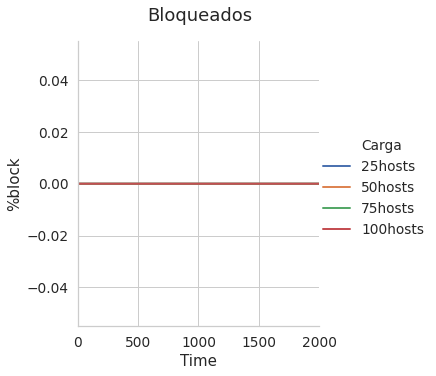

In [28]:
snsplt = sns.relplot(x="Time", y="%block",
            hue="Carga",
            kind="line", legend="full", data=df_bloqstats, ci=None)
snsplt.fig.suptitle('Bloqueados', y=1.05)
snsplt.set(xlim=(0,2000))